자산배분은 상관관계가 낮거나 음수인 우상향하는 자산들에 분산 투자하는 것입니다. 가장 기본적이고, 잘 알려진 방식은 주식 60 : 채권 40 방식입니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


ETF로 매수하는 것이 간편하니 적절한 ETF 데이터를 다운받습니다. 미국 전체 주식 ETF인 VTI와 미국 7-10년 만기 국채 IEF를 사용합니다.

In [2]:
start = '2002-08-02'
end = '2021-03-11'
vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
ief = web.DataReader("IEF", 'yahoo', start, end)['Adj Close'].to_frame("ief_Close")

In [3]:
vti.head()

,vti_Close
Date,
2002-08-01,29.226831
2002-08-02,28.546240
2002-08-05,27.594112
2002-08-06,28.493328
2002-08-07,28.941196


In [4]:
ief.head()

,ief_Close
Date,
2002-08-01,47.479900
2002-08-02,47.846680
2002-08-05,48.087341
2002-08-06,47.697678
2002-08-07,47.846680


일단 모델 포트폴리오로, 매일 60:40 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [5]:
vti_return = vti.pct_change(periods=1)
ief_return = ief.pct_change(periods=1)
df_return = pd.concat([vti_return, ief_return], axis=1)

df_return.head()

,vti_Close,ief_Close
Date,,
2002-08-01,NaN,NaN
2002-08-02,-0.023287,0.007725
2002-08-05,-0.033354,0.005030
2002-08-06,0.032587,-0.008103
2002-08-07,0.015718,0.003124


In [6]:
df_return['6040_return'] = df_return['vti_Close']*0.6 + df_return['ief_Close']*0.4
df_return.head()

,vti_Close,ief_Close,6040_return
Date,,,
2002-08-01,NaN,NaN,NaN
2002-08-02,-0.023287,0.007725,-0.010882
2002-08-05,-0.033354,0.005030,-0.018000
2002-08-06,0.032587,-0.008103,0.016311
2002-08-07,0.015718,0.003124,0.010681


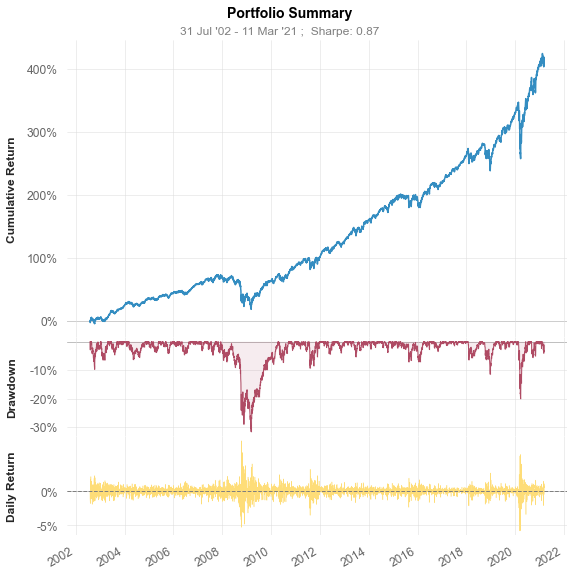

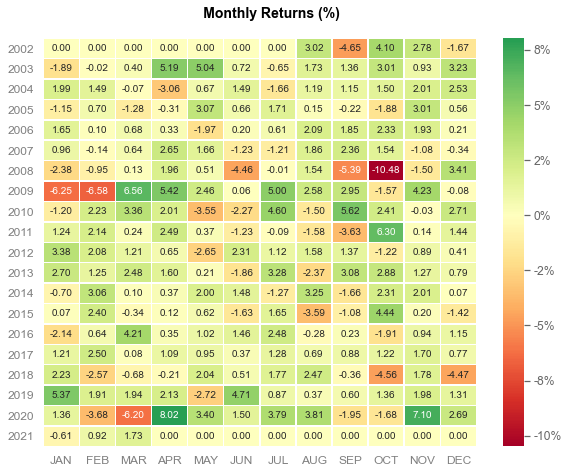

In [7]:
quantstats.reports.plots(df_return['6040_return'], mode='basic')

매일 60:40 비중을 맞춘 결과 연 복리 수익률 9.23%, 샤프 비율 0.87, MDD -31% 정도입니다.

In [8]:
quantstats.reports.metrics(df_return['6040_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2002-08-01
End Period                 2021-03-11
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          417.94%
CAGR%                      9.23%
Sharpe                     0.87
Sortino                    1.24
Max Drawdown               -31.65%
Longest DD Days            895
Volatility (ann.)          10.86%
Calmar                     0.29
Skew                       -0.1
Kurtosis                   12.97

Expected Daily %           0.04%
Expected Monthly %         0.74%
Expected Yearly %          8.57%
Kelly Criterion            8.66%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.09%
Expected Shortfall (cVaR)  -1.09%

Payoff Ratio               0.92
Profit Factor              1.18
Common Sense Ratio         1.13
CPC Index                  0.61
Tail Ratio                 0.95
Outlier Win Ratio          4.2
Outlier Loss Ratio         4.

위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [9]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
ief = ief.rename({'ief_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    ief[column] = ief["Close"]

In [10]:
vti.head()

,Close,Open,High,Low
Date,,,,
2002-08-01,29.226831,29.226831,29.226831,29.226831
2002-08-02,28.546240,28.546240,28.546240,28.546240
2002-08-05,27.594112,27.594112,27.594112,27.594112
2002-08-06,28.493328,28.493328,28.493328,28.493328
2002-08-07,28.941196,28.941196,28.941196,28.941196


60 : 40 비율로 매수하고 20 거래일마다 리밸런싱하는 전략입니다. 

In [11]:
class AssetAllocation_6040(bt.Strategy):
    params = (
        ('equity',0.6),
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.IEF = self.datas[1]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.equity)
            self.order_target_percent(self.IEF, target=(1 - self.params.equity))
        self.counter += 1

In [12]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
IEF = bt.feeds.PandasData(dataname = ief)

cerebro.adddata(VTI)
cerebro.adddata(IEF)

cerebro.addstrategy(AssetAllocation_6040)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_6040.html', title='AssetAllocation_6040')

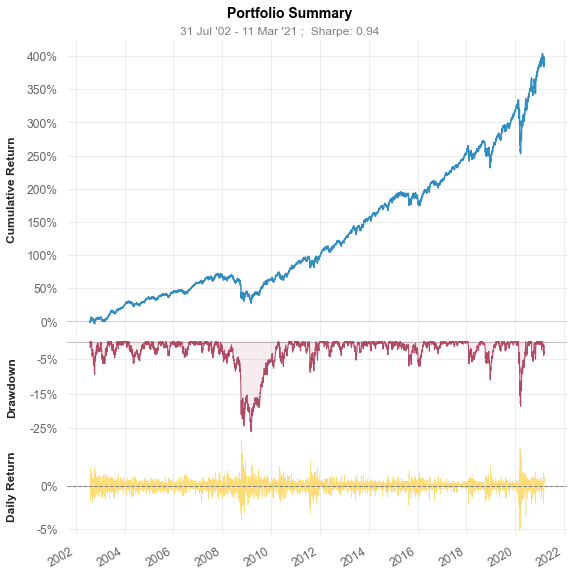

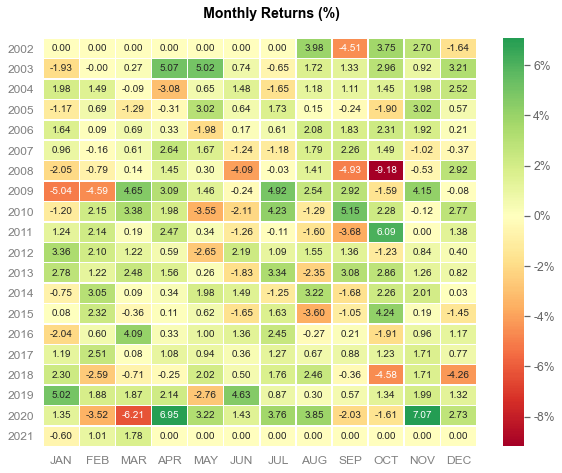

In [13]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱하는 것으로 바꾸니 연 복리 수익률 9.01%, 샤프 비율 0.94, MDD -26%로 나옵니다.

In [14]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2002-08-01
End Period                 2021-03-11
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          398.6%
CAGR%                      9.01%
Sharpe                     0.94
Sortino                    1.33
Max Drawdown               -26.04%
Longest DD Days            917
Volatility (ann.)          9.68%
Calmar                     0.35
Skew                       -0.37
Kurtosis                   8.03

Expected Daily %           0.03%
Expected Monthly %         0.72%
Expected Yearly %          8.36%
Kelly Criterion            8.85%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.97%
Expected Shortfall (cVaR)  -0.97%

Payoff Ratio               0.93
Profit Factor              1.19
Common Sense Ratio         1.16
CPC Index                  0.62
Tail Ratio                 0.98
Outlier Win Ratio          3.83
Outlier Loss Ratio         3.8

월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [15]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [16]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [17]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [18]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 월간 미국 주식(S&P 500), 월간 미국 10년 만기 국채 수익률 데이터입니다. 1900년 1월부터 2020년 12월까지 121년 기간의 테스트가 될 것입니다.

In [19]:
Monthly_6040 = MonthlyReturn.loc[:, ['S&P 500 Total return', 'US 10 YR']]
Monthly_6040.head()

,S&P 500 Total return,US 10 YR
Data Index,,
1900-01-31,0.016413,0.000000
1900-02-28,0.021138,0.011278
1900-03-31,0.011084,0.009758
1900-04-30,0.015894,-0.016107
1900-05-31,-0.044246,0.016023


In [20]:
Monthly_6040['Monthly_6040'] = Monthly_6040['S&P 500 Total return'] * 0.6 + Monthly_6040['US 10 YR'] * 0.4
Monthly_6040.head()

,S&P 500 Total return,US 10 YR,Monthly_6040
Data Index,,,
1900-01-31,0.016413,0.000000,0.009848
1900-02-28,0.021138,0.011278,0.017194
1900-03-31,0.011084,0.009758,0.010554
1900-04-30,0.015894,-0.016107,0.003094
1900-05-31,-0.044246,0.016023,-0.020139


월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1900년 1월부터 121년 동안 샤프 비율은 0.766으로 나옵니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [21]:
quantstats.stats.sharpe(Monthly_6040['Monthly_6040'])/math.sqrt(252/12)

0.7661757370916087

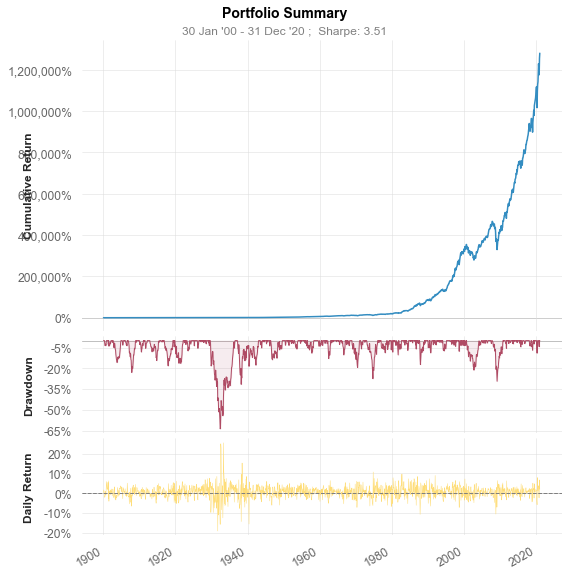

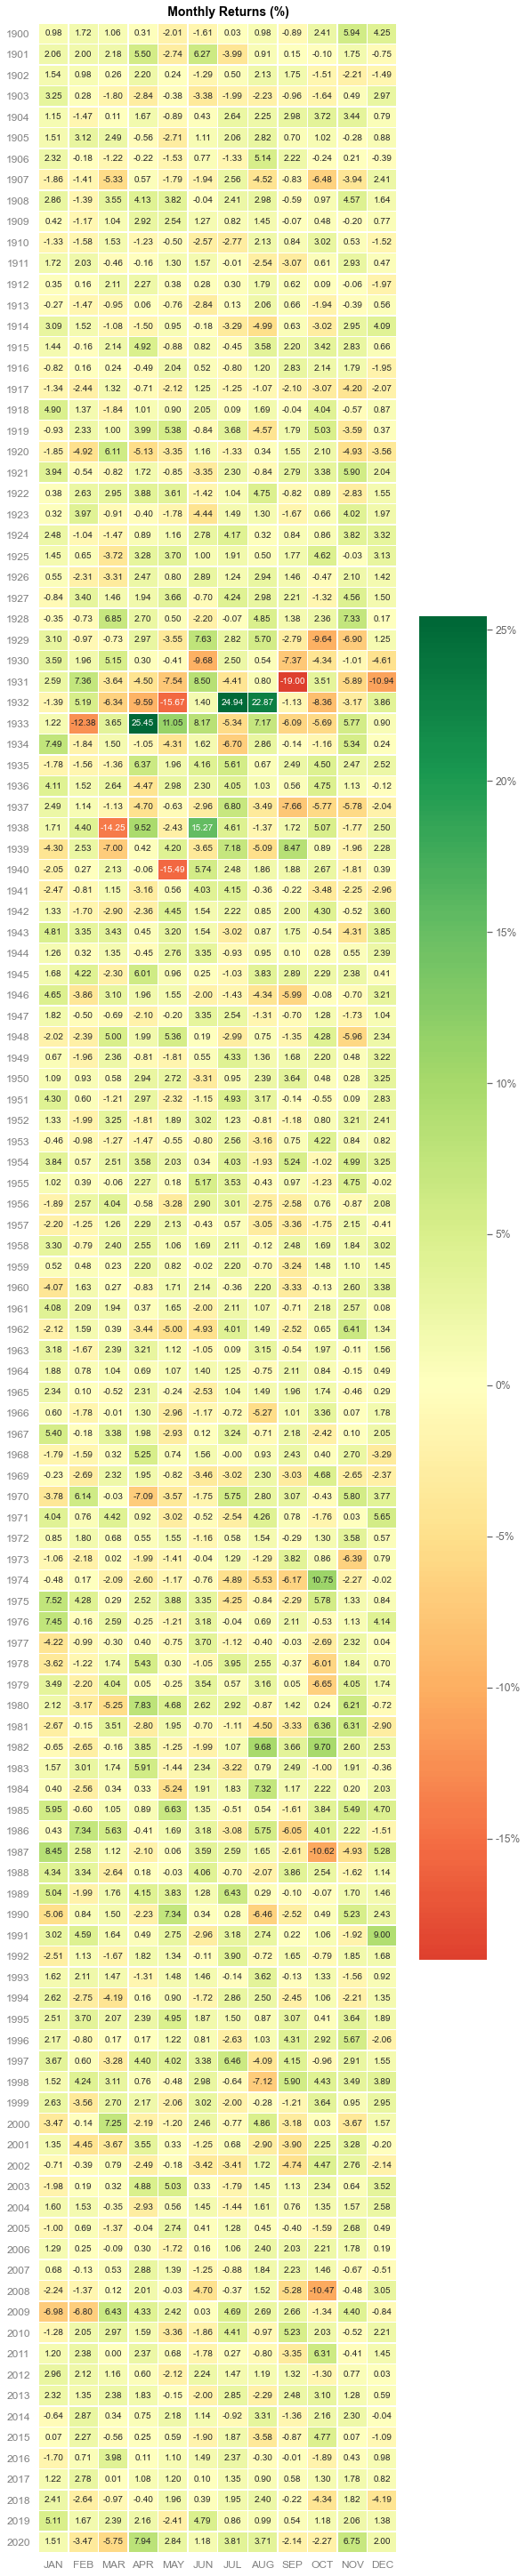

In [22]:
quantstats.reports.plots(Monthly_6040['Monthly_6040'], mode='basic')

연 복리 수익률 8.13%, 샤프 비율은 위에서 계산한대로 0.766, MDD는 대공황 시기 덕분에 -63%입니다. 매년 8%를 약간 넘는 수익이라도 121년을 하면 원금이 12800배가 됩니다. 60:40 전략은 대공황 시기가 조금 문제이지만 장기간 괜찮은 수익을 내면서도 간단한 좋은 전략입니다. 

In [23]:
quantstats.reports.metrics(Monthly_6040['Monthly_6040'], mode='full')

                           Strategy
-------------------------  -------------
Start Period               1900-01-31
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          1,280,088.84%
CAGR%                      8.13%
Sharpe                     3.51
Sortino                    5.77
Max Drawdown               -63.53%
Longest DD Days            2496
Volatility (ann.)          50.5%
Calmar                     0.13
Skew                       0.29
Kurtosis                   8.85

Expected Daily %           0.65%
Expected Monthly %         0.65%
Expected Yearly %          8.13%
Kelly Criterion            29.1%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.53%
Expected Shortfall (cVaR)  -4.53%

Payoff Ratio               1.09
Profit Factor              1.86
Common Sense Ratio         2.26
CPC Index                  1.28
Tail Ratio                 1.22
Outlier Win Ratio          3.26
Outlier Loss Ratio  